In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!pip install pandas
#!pip install tqdm

#!pip install scipy
#!pip install matchms
#!pip install scikit-learn
#!pip install spec2vec
#!pip install seaborn

In [3]:
import os
os.chdir('/Users/sebas/projects/metabolomics')
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [4]:
from src.transformers.sklearn_model import SklearnModel

In [5]:
import gensim
from src.load_data import LoadData
from src.config import Config
from matchms import calculate_scores
from matchms.importing import load_from_mgf,load_from_msp
import matchms.filtering as msfilters
from spec2vec import SpectrumDocument
from torch.utils.data import DataLoader, WeightedRandomSampler
from spec2vec.model_building import train_new_word2vec_model
from tqdm import tqdm
from src.loader_saver import LoaderSaver
import itertools
from pytorch_lightning.callbacks import ProgressBar
from src.losscallback import LossCallback
import numpy as np
from matchms.importing import load_from_msp
from matchms.similarity import ModifiedCosine
from scipy.stats import spearmanr
import dill
from src.weight_sampling import WeightSampling
from src.plotting import Plotting
from torch.utils.data import DataLoader, WeightedRandomSampler
import lightning.pytorch as pl
from src.load_data import LoadData
from sklearn.model_selection import train_test_split
from src.train_utils import TrainUtils
from src.preprocessor import Preprocessor
from matchms.filtering import add_fingerprint
import pickle
import sys
from src.config import Config
from src.parser import Parser
from datetime import datetime
from src.loader_saver import LoaderSaver
from src.spec2vec_comparison import Spec2VecComparison
from src.ms2deepscore_comparison import MS2DeepScoreComparison
from src.molecule_pairs_opt import MoleculePairsOpt
from scipy.stats import spearmanr
from src.transformers.load_data import LoadData as LoadDataTrans
from src.transformers.load_data_unique import LoadDataUnique

In [6]:
from src.transformers.embedder import Embedder

In [7]:
ls /Users/sebas/projects/data

ALL_GNPS_NO_PROPOGATED_wb.mgf
GNPS-NIH-NATURALPRODUCTSLIBRARY.mgf
all_spectrums_gnps.pkl
all_spectrums_gnps_nist_20240130_gnps_nist_janssen.pkl
all_spectrums_janssen.pkl
all_spectrums_nist.pkl
best_model.ckpt
best_model_128n_10_layers_20240209.ckpt
best_model_128n_5_layers_20240219_elementwise.ckpt
best_model_128n_5_layers_20240229.ckpt
best_model_128n_5_layers_20240303.ckpt
best_model_20240301.ckpt
drug_plus.mgf
hr_msms_nist_all.MSP*
hr_msms_nist_sample.MSP
merged_gnps_nist_20240118_gnps_nist_janssen.pkl
merged_gnps_nist_20240207_gnps_nist_janssen_15_millions.pkl
merged_gnps_nist_20240227_gnps_nist_janssen_20_millions_OUTSIDE_MAX_DIFF_NO_JANSSEN.pkl
merged_gnps_nist_20240311_unique_smiles_1_million.pkl
ms2deepscore_positive_10k_1000_1000_1000_500.hdf5
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model.trainables.syn1neg.npy
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model.wv.vectors.npy
to_export_gnps_nist.pk

## Parameters

In [8]:
data_folder= '/Users/sebas/projects/data/'
dataset_path = data_folder + 'uniformed_molecule_pairs_test.pkl'
gnps_path =  data_folder + 'ALL_GNPS_NO_PROPOGATED_wb.mgf'
janssen_path = data_folder + 'drug_plus.mgf'
nist_path = data_folder + 'hr_msms_nist_all.MSP'
output_pairs_file= data_folder + 'molecular_pairs.pkl'
output_nist_file= data_folder + 'all_spectrums_nist.pkl'
output_gnps_file= data_folder + 'all_spectrums_gnps.pkl'
output_janssen_file= data_folder + 'all_spectrums_janssen.pkl'
model_spec2vec_file = data_folder + 'spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model'
model_ms2d_file= data_folder + 'ms2deepscore_positive_10k_1000_1000_1000_500.hdf5'
#uniformed_molecule_pairs_test_path= data_folder +'uniformed_molecule_pairs_test.pkl'
uniformed_molecule_pairs_test_path= data_folder +'merged_gnps_nist_20240207_gnps_nist_janssen_15_millions.pkl'
#uniformed_molecule_pairs_test_path= data_folder + 'merged_gnps_nist_20240311_unique_smiles_1_million.pkl'
transformer_path = data_folder + 'best_model_128n_5_layers_20240219_elementwise.ckpt'

In [9]:
THRESHOLD_ANALOG=0.7

In [10]:
load_molecule_pairs_file= True
only_use_gnps=False

In [11]:
## Load spectrum using spectrumutils

In [12]:
config=Config()

In [13]:
config.CHECKPOINT_DIR = './notebooks/cosine/results'
config.use_cosine_distance=True

In [14]:
#config.LR=0.000001
#config.LR=0.000001

In [15]:
NUMBER_TRAIN_PAIRS=10000

## Load molecular pairs

In [16]:
uniformed_molecule_pairs_test_path

'/Users/sebas/projects/data/merged_gnps_nist_20240207_gnps_nist_janssen_15_millions.pkl'

In [17]:

if load_molecule_pairs_file:
        with open(uniformed_molecule_pairs_test_path, 'rb') as file:
            dataset = dill.load(file)


In [18]:
molecule_pairs_train= dataset['molecule_pairs_train']
molecule_pairs_val= dataset['molecule_pairs_val']

In [19]:
molecule_pairs_train

In [20]:
molecule_pairs_val

## Our model

In [21]:
from src.transformers.sklearn_model import SklearnModel

In [22]:
# Generate an array of 10 random integers between 0 and 100
random_integers_train = np.random.randint(0, len(molecule_pairs_train), NUMBER_TRAIN_PAIRS)
random_integers_val = np.random.randint(0, len(molecule_pairs_val), NUMBER_TRAIN_PAIRS)

In [23]:
#molecule_pairs_train= MolecularPairsSet(spectrums= molecule_pairs_train.spectrums, 
#                                      indexes_tani =molecule_pairs_train.indexes_tani[random_integers_train])
#molecule_pairs_val= MolecularPairsSet(spectrums= molecule_pairs_val.spectrums, 
#                                      indexes_tani =molecule_pairs_val.indexes_tani[random_integers_val])
molecule_pairs_train= MoleculePairsOpt(
            spectrums_unique=molecule_pairs_train.spectrums,
            indexes_tani_unique= molecule_pairs_train.indexes_tani[random_integers_train],
            spectrums_original=molecule_pairs_train.spectrums_original,
            df_smiles=molecule_pairs_train.df_smiles,
        )
molecule_pairs_val= MoleculePairsOpt(
            spectrums_unique=molecule_pairs_val.spectrums,
            indexes_tani_unique= molecule_pairs_val.indexes_tani[random_integers_val],
            spectrums_original=molecule_pairs_val.spectrums_original,
            df_smiles=molecule_pairs_val.df_smiles,
        )

AttributeError: 'MolecularPairsSet' object has no attribute 'spectrums_original'

In [25]:
def divide_data_into_bins(
        molecule_pairs,
        number_bins,
        bin_sim_1=True,  # if you want to try sim=1 as a different bin
    ):
        # Initialize lists to store values for each bin
        binned_molecule_pairs = []

        # Group the values into the corresponding bins, adding one for sim=1
        if bin_sim_1:
            number_bins_effective = number_bins + 1
        else:
            number_bins_effective = number_bins

        for p in range(number_bins_effective):
            low = p * (1 / number_bins)

            if bin_sim_1:
                high = (p + 1) * (1 / number_bins)
            else:
                if p == (number_bins_effective - 1):
                    high = 1 + 0.1
                else:
                    high = (p + 1) * (1 / number_bins)

            # temp_molecule_pairs = [m for m in molecule_pairs if ((m.similarity>=low) and (m.similarity<high))]
            # check the similarity
            # temp_indexes_tani = np.array([ row for row in molecule_pairs.indexes_tani if ((row[2]>=low) and (row[2]<high)) ])
            temp_indexes_tani = molecule_pairs.indexes_tani[
                (molecule_pairs.indexes_tani[:, 2] >= low)
                & (molecule_pairs.indexes_tani[:, 2] < high)
            ]

            temp_molecule_pairs =temp_indexes_tani
            binned_molecule_pairs.append(temp_molecule_pairs)

        # get minimum bin size
        min_bin = min([len(b) for b in binned_molecule_pairs])
        return binned_molecule_pairs, min_bin

In [27]:
## CALCULATION OF WEIGHTS
train_binned_list, _ = divide_data_into_bins(
    molecule_pairs_train, config.bins_uniformise_TRAINING,
)

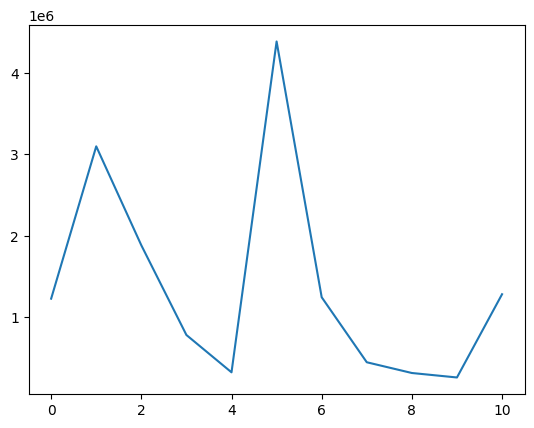

In [31]:
import matplotlib.pyplot as plt
plt.plot([len(t) for t in train_binned_list])

In [389]:
weights, range_weights = WeightSampling.compute_weights(train_binned_list)

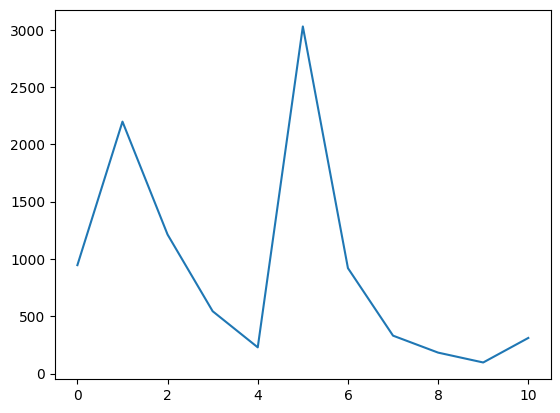

In [390]:
import matplotlib.pyplot as plt
plt.plot([len(t) for t in train_binned_list])

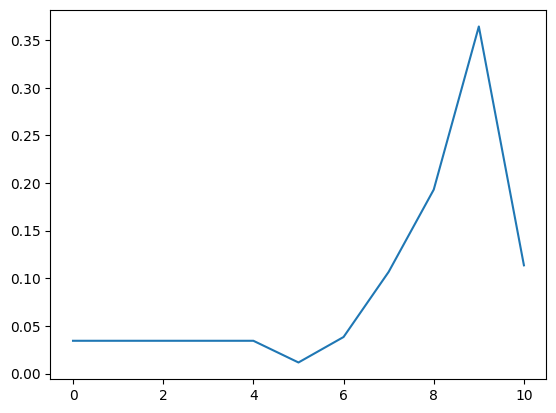

In [391]:
plt.plot(weights)

In [353]:
weights

array([0.03306582, 0.01423124, 0.02578752, 0.05750048, 0.13659504,
       0.01033034, 0.03400029, 0.09450231, 0.1709304 , 0.32247694,
       0.10057963])

In [354]:
range_weights

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

(array([8305.,  544.,  642.,    0.,  229.,  183.,    0.,    0.,    0.,
          97.]),
 array([3.00228173e-05, 1.20741248e-04, 2.11459678e-04, 3.02178109e-04,
        3.92896540e-04, 4.83614970e-04, 5.74333401e-04, 6.65051831e-04,
        7.55770262e-04, 8.46488692e-04, 9.37207123e-04]),
 <BarContainer object of 10 artists>)

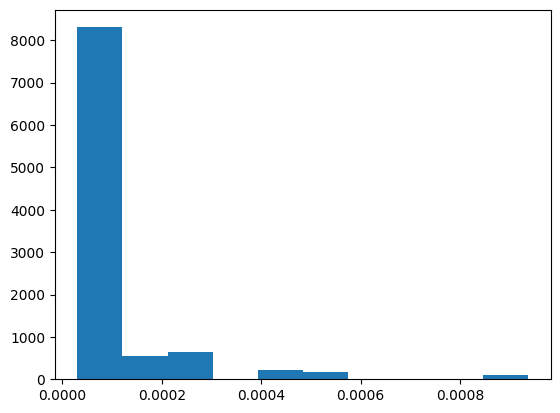

In [371]:
plt.hist(weights_tr)

In [360]:
weights_tr = WeightSampling.compute_sample_weights(molecule_pairs_train, weights)
weights_val = WeightSampling.compute_sample_weights(molecule_pairs_val, weights)

In [361]:
molecule_pairs_train[0].similarity

0.5015197396278381

In [362]:
weights_tr[0]

3.0022817341178874e-05

In [367]:
molecule_pairs_train[0].similarity

0.5015197396278381

In [368]:
weights_tr[0]

3.0022817341178874e-05

In [279]:
dataset_train = LoadDataUnique.from_molecule_pairs_to_dataset(molecule_pairs_train, training=True)
# dataset_test = LoadData.from_molecule_pairs_to_dataset(m_test)
dataset_val = LoadDataUnique.from_molecule_pairs_to_dataset(molecule_pairs_val)

Preprocessing all the data ...



0it [00:00, ?it/s]
4015it [00:00, 40148.51it/s]
8030it [00:00, 27840.33it/s]
11032it [00:00, 22070.00it/s]
14348it [00:00, 25267.50it/s]
21634it [00:00, 39152.43it/s]
28758it [00:00, 48591.38it/s]
36672it [00:00, 57629.10it/s]
44656it [00:00, 64227.33it/s]
53016it [00:01, 69999.40it/s]
61682it [00:01, 74972.90it/s]
69972it [00:01, 77336.89it/s]
77847it [00:01, 77759.55it/s]
85720it [00:01, 77316.39it/s]
93674it [00:01, 77976.93it/s]
101718it [00:01, 78708.70it/s]
110006it [00:01, 79952.43it/s]
118151it [00:01, 80399.24it/s]
126209it [00:01, 79706.84it/s]
134226it [00:02, 79843.02it/s]
142835it [00:02, 81705.10it/s]
151160it [00:02, 82164.10it/s]
159387it [00:02, 82192.81it/s]
167611it [00:02, 81976.22it/s]
175883it [00:02, 82196.64it/s]
184105it [00:02, 81132.33it/s]
192223it [00:02, 81013.06it/s]
200328it [00:02, 80951.06it/s]
208532it [00:02, 81273.83it/s]
216682it [00:03, 81338.95it/s]
225166it [00:03, 82385.47it/s]
233406it [00:03, 81549.21it/s]
241783it [00:03, 82207.92it/s]
2502

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries
Preprocessing all the data ...



0it [00:00, ?it/s]
3628it [00:00, 36278.13it/s]
11850it [00:00, 63299.65it/s]
20221it [00:00, 72618.06it/s]
31318it [00:00, 72493.02it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


In [280]:
next(iter(dataset_train))

{'mz_0': array([ 56.0493, 122.0773, 128.0867, 145.1134, 148.093 , 165.1195,
          0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
          0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
          0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
          0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
          0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
          0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
          0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
          0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
          0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
          0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
          0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
          0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
          0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
          0.    ,   0.    ,   0.    ,   

In [281]:
train_sampler = WeightedRandomSampler(
    weights=weights_tr, num_samples=len(dataset_train), replacement=True
)
val_sampler = WeightedRandomSampler(
    weights=weights_val, num_samples=len(dataset_val), replacement=True
)


In [282]:
dataloader_train = DataLoader(
    dataset_train, batch_size=config.BATCH_SIZE,  num_workers=10, sampler=train_sampler,
)
def worker_init_fn(
    worker_id,
):  # ensure the dataloader for validation is the same for every epoch
    seed = 42
    torch.manual_seed(seed)
    # Set the same seed for reproducibility in NumPy and Python's random module
    np.random.seed(seed)
    random.seed(seed)

dataloader_val = DataLoader(
    dataset_val,
    batch_size=config.BATCH_SIZE,
    num_workers=0,
    sampler=val_sampler,
)


In [283]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=config.CHECKPOINT_DIR,
    filename="best_model",
    monitor="validation_loss_epoch",
    mode="min",
    save_top_k=1,
)

# checkpoint_callback = SaveBestModelCallback(file_path=config.best_model_path)
progress_bar_callback = ProgressBar()

# loss callback
losscallback = LossCallback(file_path=config.CHECKPOINT_DIR + f"loss.png")

print("define model")


    
model = Embedder(
        d_model=int(config.D_MODEL),
        n_layers=int(config.N_LAYERS),
        weights=None,
        lr=config.LR,
        use_cosine_distance=config.use_cosine_distance,
    )

define model


In [284]:
config.LR

0.0001

In [285]:
trainer = pl.Trainer(
    max_epochs=100,
    callbacks=[checkpoint_callback, losscallback],
    enable_progress_bar=True,
    # val_check_interval= config.validate_after_ratio,
)
# trainer = pl.Trainer(max_steps=100,  callbacks=[checkpoint_callback, losscallback], enable_progress_bar=enable_progress_bar)
trainer.fit(
    model=model,
    train_dataloaders=(dataloader_train),
    val_dataloaders=dataloader_val,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /Users/sebas/projects/metabolomics/notebooks/cosine/results exists and is not empty.

  | Name                    | Type                             | Params
-----------------------------------------------------------------------------
0 | linear                  | Linear                           | 16.5 K
1 | linear_regression       | Linear                           | 129   
2 | fixed_linear_regression | FixedLinearRegression            | 129   
3 | relu                    | ReLU                             | 0     
4 | spectrum_encoder        | SpectrumTransformerEncoderCustom | 1.7 M 
5 | regression_loss         | MSELoss                          | 0     
6 | dropout                 | Dropou

Sanity Checking: |                                                                                            …

/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lea

Train loss:
[]
Validation loss
[1.436506748199463]


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |                                                                                                   …

Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Validation: |                                                                                                 …

Train loss:
[]
Validation loss
[1.436506748199463, 1.1950141191482544]


Validation: |                                                                                                 …

Train loss:
[0.3884230852127075]
Validation loss
[1.436506748199463, 1.1950141191482544, 1.0992369651794434]


Validation: |                                                                                                 …

Train loss:
[0.3884230852127075, 0.35413989424705505]
Validation loss
[1.436506748199463, 1.1950141191482544, 1.0992369651794434, 1.1861121654510498]


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x116ca3b00>
Traceback (most recent call last):
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1437, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Error in callback <function flush_figures at 0x38f1a7060> (for post_execute), with arguments args (),kwargs {}:


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/torch/__init__.py", line 237, in <module>
    from torch._C import *  # noqa: F403
    ^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt

KeyboardInterrupt



In [286]:
for name, param in model.named_parameters():
    print(name)
    print(param)

linear.weight
Parameter containing:
tensor([[-0.0337,  0.0788, -0.0199,  ..., -0.0222,  0.0206, -0.0046],
        [ 0.0377,  0.0126, -0.0278,  ...,  0.0850, -0.0720,  0.0671],
        [ 0.0457, -0.0515, -0.0832,  ..., -0.0338,  0.0328,  0.0318],
        ...,
        [-0.0523, -0.0666, -0.0808,  ..., -0.0269,  0.0770, -0.0449],
        [-0.0148, -0.0291,  0.0715,  ...,  0.0034, -0.0413,  0.0193],
        [-0.0156, -0.0654,  0.0309,  ...,  0.0879, -0.0276, -0.0720]],
       device='mps:0', requires_grad=True)
linear.bias
Parameter containing:
tensor([ 0.0014, -0.0315,  0.0187, -0.0423,  0.0313,  0.0742, -0.0020, -0.0851,
        -0.0762, -0.0118,  0.0105, -0.0559, -0.0713, -0.0014,  0.0874, -0.0331,
         0.0616,  0.0547, -0.0502, -0.0278, -0.0688,  0.0493,  0.0369,  0.0167,
        -0.0226, -0.0785, -0.0671,  0.0587, -0.0369, -0.0406,  0.0381,  0.0721,
        -0.0232, -0.0389,  0.0642, -0.0127, -0.0142,  0.0385, -0.0790,  0.0018,
        -0.0372, -0.0485, -0.0834, -0.0532,  0.0272, 

KeyboardInterrupt: 